In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle
import os
import cv2

## preprocess DATA

### unify image sizes

In [10]:
cwd = os.getcwd()
datasetpath = os.path.join(cwd,"dataset")
labels = os.listdir(datasetpath)
for l in labels:
    directory = os.path.join(datasetpath,l)
    images = os.listdir(directory)
    images = [i for i in images if images[0]!="."]
    for image in images:
        image_path = os.path.join(directory,image)
        img = cv2.imread(image_path)
        if not(type(img)=='NoneType'):
            img = cv2.resize(img,(240,240),interpolation=cv2.INTER_CUBIC)
            cv2.imwrite(image_path,img)

### label encoder

In [11]:
idx2label = {}
for i in range(0,len(labels)):
    idx2label[i]=labels[i]

In [12]:
datagen = ImageDataGenerator(rescale=1.0/255.)

In [13]:
generator = datagen.flow_from_directory(datasetpath,
                                        batch_size=40,
                                        class_mode='categorical',
                                        target_size=(240, 240))

Found 38931 images belonging to 30 classes.


## DEFINE MODEL

In [28]:
model = Sequential([
    Conv2D(16, (1, 1), activation='relu', input_shape=(240, 240, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(labels), activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 240, 240, 16)      64        
                                                                 
 conv2d_10 (Conv2D)          (None, 238, 238, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 119, 119, 32)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 117, 117, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 58, 58, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 56, 56, 64)       

### Compile Model

In [29]:
opt = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

# TRAIN & visualize

In [30]:
from keras.callbacks import ModelCheckpoint
filepath = "model_weights_saved.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
desired_callbacks = [checkpoint]

In [31]:
history = model.fit(generator,
                    epochs=20,
                    verbose=1,
                    callbacks=desired_callbacks)

Epoch 1/20
974/974 [==============================] - ETA: 0s - loss: 1.1148 - accuracy: 0.6841
Epoch 00001: loss improved from inf to 1.11482, saving model to model_weights_saved.hdf5
974/974 [==============================] - 198s 203ms/step - loss: 1.1148 - accuracy: 0.6841
Epoch 2/20
974/974 [==============================] - ETA: 0s - loss: 0.6617 - accuracy: 0.8004
Epoch 00002: loss improved from 1.11482 to 0.66165, saving model to model_weights_saved.hdf5
974/974 [==============================] - 201s 206ms/step - loss: 0.6617 - accuracy: 0.8004
Epoch 3/20
974/974 [==============================] - ETA: 0s - loss: 0.4878 - accuracy: 0.8461
Epoch 00003: loss improved from 0.66165 to 0.48778, saving model to model_weights_saved.hdf5
974/974 [==============================] - 205s 210ms/step - loss: 0.4878 - accuracy: 0.8461
Epoch 4/20
974/974 [==============================] - ETA: 0s - loss: 0.3795 - accuracy: 0.8783
Epoch 00004: loss improved from 0.48778 to 0.37951, saving mod

In [35]:
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

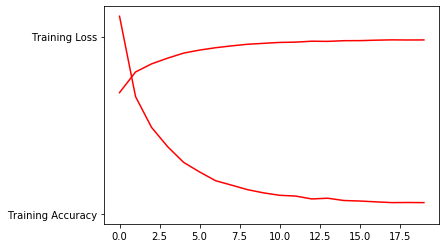

<Figure size 432x288 with 0 Axes>

In [37]:
acc=history.history['accuracy']
loss=history.history['loss']
epochs=range(len(acc)) 
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, loss, 'r', "Training Loss")
plt.figure()

## save Model

In [38]:
idx2label

{0: 'battery',
 1: 'button',
 2: 'buzzer',
 3: 'capacitor',
 4: 'clock',
 5: 'component',
 6: 'connector',
 7: 'diode',
 8: 'display',
 9: 'electrolytic',
 10: 'emi',
 11: 'ferrite',
 12: 'fuse',
 13: 'heatsink',
 14: 'ic',
 15: 'inductor',
 16: 'jumper',
 17: 'led',
 18: 'not_component',
 19: 'pads',
 20: 'pins',
 21: 'potentiometer',
 22: 'resistor',
 23: 'switch',
 24: 'test',
 25: 'text',
 26: 'transformer',
 27: 'transistor',
 28: 'unknown',
 29: 'zener'}

In [40]:
MODEL_PATH = os.path.join(cwd,"component_classifier.h5")
ENCODER_PATH = os.path.join(cwd,"label_encoder.pickle")

In [41]:
model.save(MODEL_PATH, save_format="h5")
f = open(ENCODER_PATH, "wb")
f.write(pickle.dumps(idx2label))
f.close()